In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import json
import datetime

import numpy as np
import pandas as pd
import networkx as nx

In [3]:
time_format = "%a %b %d %H:%M:%S +0000 %Y"

In [4]:
def str_to_json(json_str):    
    try:
        tweet = json.loads(json_str)
        return tweet
    except ValueError as ve:
        return None

In [5]:
rdd = sc.textFile("/scratch/clb617/data/wri/wri_2018/data/stream_0{1,3,4}/statuses.*.gz")
tweets_ = rdd.map(str_to_json).filter(lambda t: t != None and len(t) > 0)
tweets = tweets_.map(lambda t: (t["id"], t)).reduceByKey(lambda l, r: l).map(lambda tup: tup[1]).cache()

In [6]:
def retweet_edges(tweet):
    edges = []
    if ( "retweeted_status" in tweet ):
        edges.append((tweet["user"]["screen_name"], tweet["retweeted_status"]["user"]["screen_name"]))
    return edges

In [7]:
edges = tweets.flatMap(retweet_edges).collect()

In [8]:
len(edges)

560364

In [9]:
edges[0]

('OurSustWorld', 'GlobalLF')

In [10]:
# We'll use a directed graph since mentions/retweets are directional
graph = nx.DiGraph()

for source, sink in edges:
    if ( graph.has_node(source) == False ):
        graph.add_node(source)
    if ( graph.has_node(sink) == False ):
        graph.add_node(sink)

    if ( graph.has_edge(source, sink)):
        graph[source][sink]["weight"] += 1
    else:
        graph.add_edge(source, sink, weight=1)

In [13]:
len(graph.edges()), len(graph.nodes())

(395504, 239975)

In [14]:
major_density = nx.density(graph)
print("Graph Density:", major_density)

Graph Density: 6.867848229135821e-06


Max: 21773
Median: 1.0
Mean: 3.29621002188


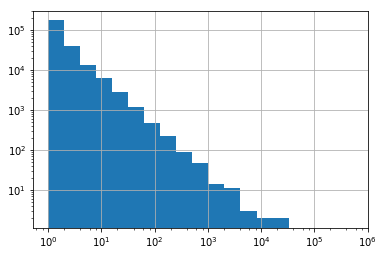

In [20]:
# Histogram over degrees
degrees = [d for n,d in graph.degree().items()]

print("Max:", np.max(degrees))
print("Median:", np.median(degrees))
print("Mean:", np.mean(degrees))

plt.hist(degrees, bins=[2**x for x in range(20)])
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.grid()
plt.show()

In [24]:
subnodes = [n for n,d in graph.degree().items() if d > 3]
print("Subnodes:", len(subnodes))
subgraph = graph.subgraph(subnodes)

Subnodes: 24826


In [ ]:
# THis may take a while
pageRankList = nx.pagerank_numpy(subgraph)
highRankNodes = sorted(pageRankList.keys(), key=pageRankList.get, reverse=True)
for x in highRankNodes[:40]:
    print (x, pageRankList[x])

In [27]:
for x in highRankNodes[:40]:
    print (x, pageRankList[x])

alvaro_delgado 0.06824495058118016
UNFCCC 0.018848146417578544
UNEnvironment 0.01348424325737036
ErikSolheim 0.010285633353738192
epigmenioibarra 0.00944239576173016
FelipeCalderon 0.008227487419121646
BBCAfrica 0.0070784770885248295
AfDB_Group 0.006695895295408355
BiancaJagger 0.006296626069376612
lovrega 0.006005325592630739
_markgerard 0.00590893222341568
PEspinosaC 0.005687933055169358
GlobalLF 0.0052622069790350685
WorldBank 0.004616530261101436
antonioguterres 0.004352548745816838
m_zamarripa 0.0038058021991614578
JoyceMsuya 0.003381809820639711
camilocnn 0.003359332632830815
AntiTelevisaMx 0.0031927571309385474
scbc_tv 0.003170772664283517
UN 0.003021513617182325
fernandeznorona 0.0029460301054724898
AvilRamirez 0.0027122540009128647
BBCMonitoring 0.0026028315793371797
RichardMunang 0.0025819573235479278
MADREABC 0.0025599990791374755
Secominfo 0.0024701203368189453
cesamo70 0.002427895349145821
ReutersAfrica 0.0023664763794948927
RnfrstAlliance 0.0022584950963343143
IUCN 0.0021

In [28]:
centrality_list = nx.degree_centrality(graph)
highRankNodes = sorted(centrality_list.keys(), key=centrality_list.get, reverse=True)
for x in highRankNodes[:40]:
    print (x, centrality_list[x])

BBCAfrica 0.09073066248843625
DanRather 0.07166609716052573
UNEnvironment 0.03823330860843258
UNFCCC 0.03602473601306808
EdKrassen 0.02996157917107687
FelipeCalderon 0.02904064606999092
WorldBank 0.025027711335394668
alvaro_delgado 0.01664763682732296
epigmenioibarra 0.015109970246776735
ErikSolheim 0.013434788768783285
DivinoTormento9 0.012409677715085802
AfDB_Group 0.012155483510713662
WWF 0.011509580204522158
BiancaJagger 0.011280388708776784
lovrega 0.011097035512180487
annaazul 0.00977605907306625
MichaelAvenatti 0.009642711293723486
TAMARA_SUJU 0.008850958853875837
ReutersAfrica 0.008275896555460176
tumbaburross 0.008021702351088036
fernandeznorona 0.006734062856809488
RnfrstAlliance 0.006309016810154434
SOSOrinoco 0.006271512747214282
aaronramsey 0.006259011392900898
OlumideIDOWU 0.006229841566169669
AntiTelevisaMx 0.005242234575412337
Actor_Vivek 0.00515889221332311
UN 0.005113053914174036
GlobalLF 0.004800520056339437
AWF_Official 0.004796352938234976
m_zamarripa 0.00459216415

In [ ]:
centrality_list = nx.betweenness_centrality(subgraph)
highRankNodes = sorted(centrality_list.keys(), key=centrality_list.get, reverse=True)
for x in highRankNodes[:40]:
    print (x, centrality_list[x])

In [31]:
for x in highRankNodes[:40]:
    print (x, centrality_list[x])

GlobalLF 0.09281865576479627
FelipeCalderon 0.07811078739727247
NewClimateEcon 0.042722104463041956
WorldResources 0.0343091329783898
OlumideIDOWU 0.03338048867818583
BiancaJagger 0.0315578962484588
ClimateWed 0.029783641820102708
UNEnvironment 0.024096547518292957
EWestaway 0.01837549571703096
restoreforward 0.016512461594159214
ErikSolheim 0.015618272213576737
roblesmaloof 0.015277290159495681
skyaquaklin 0.012800837111633673
estherclimate 0.012400360837312382
WWF 0.011078133273247349
AleJuarezA 0.01064793197860951
FDHS_MX 0.010464969386172546
m_zamarripa 0.01042548542319983
annaazul 0.010329028708024044
TomLendo 0.010200315537512794
RichardMunang 0.009833995995162487
missing_bc 0.00973979163368465
climateWWF 0.009488370710083188
theGEF 0.009216066666340863
TabiJoda1 0.008581193098971263
MADREABC 0.00800488861557455
AfDB_Group 0.007854244904214141
aleket6 0.007712060739639979
choi_afdb 0.007703389835951189
caroescer 0.0071477047448038926
RnfrstAlliance 0.007013090923900804
UgochiTVCN

In [10]:
community_df = pd.read_csv("retweets_communities_2018.csv")
communities = set(community_df.community)
known_users = set()

community_map = {x:[] for x in communities}
for idx, row in community_df.iterrows():
    community_map[row.community].append(row.user)
    known_users.add(row.user)

In [11]:
def retweet_edges_ids(tweet):
    edges = []
    if ( "retweeted_status" in tweet ):
        edges.append((tweet["user"]["id"], tweet["retweeted_status"]["user"]["id"]))
    return edges
edges = tweets.flatMap(retweet_edges_ids).collect()

# We'll use a directed graph since mentions/retweets are directional
rtgraph = nx.DiGraph()

for source, sink in edges:
    if ( rtgraph.has_node(source) == False ):
        rtgraph.add_node(source)
    if ( rtgraph.has_node(sink) == False ):
        rtgraph.add_node(sink)

    if ( rtgraph.has_edge(source, sink)):
        rtgraph[source][sink]["weight"] += 1
    else:
        rtgraph.add_edge(source, sink, weight=1)
        
len(rtgraph.edges()), len(rtgraph.nodes())

(395143, 239592)

In [12]:
def tweet_to_names(tweet):
    pairs = [(tweet["user"]["id"], tweet["user"]["screen_name"])]
    
    if ( "retweeted_status" in tweet ):
        retweet = tweet["retweeted_status"]
        pairs.append((retweet["user"]["id"], retweet["user"]["screen_name"]))
        
    for mention in tweet["entities"]["user_mentions"]:
        pairs.append((mention["id"], mention["screen_name"]))
        
    return pairs

user_ids_to_names_ = tweets.flatMap(tweet_to_names)\
    .reduceByKey(lambda l,r: l).collect()
user_ids_to_names = dict(user_ids_to_names_)    

In [18]:
my_log = open("wri_2018_retweets.log", "w")
def lprint(*s):
    new_str = " ".join([str(x) for x in s])
    print(new_str)
    my_log.write(new_str + "\n")
    my_log.flush()

def draw_graph(graph, name):
    """
    Function for drawing a given graph using the spring layout
    algorithm.
    """
    
    nx.write_graphml(graph, name)
    
    node_degrees = graph.degree()
#     avg_degree = np.mean([x[1] for x in node_degrees])
    avg_degree = np.percentile([x[1] for x in node_degrees], 95)
    interesting_nodes = [x[0] for x in node_degrees if x[1] > avg_degree]
    subg = graph.subgraph(interesting_nodes)
    
    plt.figure(figsize=(8,8))
#     pos = nx.spring_layout(graph, scale=200, iterations=100, k=0.2)
    pos = nx.fruchterman_reingold_layout(subg, weight="weight", iterations=100)
    # pos = nx.random_layout(graph)
    nx.draw(subg, 
            pos, 
            node_color='#A0CBE2', 
            width=1, 
            with_labels=True,
            node_size=[(x[1]-avg_degree+1)*100 for x in subg.degree()])

    plt.axis('off')
    plt.show()
    
def is_in_user_id(tweet, user_ids):
    flag = tweet["user"]["id"] in user_ids
    if ( flag == False ):
        if ( "retweeted_status" in tweet ):
            flag = tweet["retweeted_status"]["user"]["id"] in user_ids
    return flag

def plot_times(tweets, user_ids, fig_name="times.pdf"):
    time_tweets = tweets.map(lambda tweet: (datetime.datetime.strptime(tweet["created_at"], time_format), 1))\
        .reduceByKey(lambda l, r: l + r).collect()
        
    df = pd.DataFrame(time_tweets)
    df.columns = ["time", "posts"]
    df.index = df["time"]
    df.resample("D").sum().plot()
    plt.grid()
    plt.savefig(fig_name, format="pdf")
    plt.show()
    return None
    
def find_auth_nodes(graph, user_ids_to_names, limit=5):
    """
    Given a NetworkX Graph structure, use PageRank to find the most
    authoritative nodes in the graph.
    """
    
    # THis may take a while
    local_pg_rank = nx.pagerank_numpy(graph)
    
    # Rank the users by their PageRank score, and reverse the list
    #  so we can get the top users in the front of the list
    local_auths = sorted(local_pg_rank.keys(), key=local_pg_rank.get, reverse=True)
    
    # Take only the first few users
    local_targets = local_auths[:limit]

    # Print user name and PageRank score
    lprint("\tTop Users:")
    for x in local_targets:
        lprint("\t\t", x, user_ids_to_names[x], local_pg_rank[x])
        
    # In case we want to use these usernames later
    return local_pg_rank

def user_hashtags(filtered_tweets, limit=5):
    """
    Simple function that prints the top few most frequent hashtags
    """
    
    # This list comprehension iterates through the tweet_list list, and for each
    #  tweet, it iterates through the hashtags list
    hashtag_counts = filtered_tweets.flatMap(lambda tweet: [(hashtag["text"].lower(), 1) for hashtag in tweet["entities"]["hashtags"]])\
        .reduceByKey(lambda l, r: l + r)\
        .collect()

    sorted_hashtags = sorted(hashtag_counts, key=lambda x: x[1], reverse=True)
    lprint("\tFrequent Hashtags:")
    for tag, count in sorted_hashtags[:limit]:
        lprint("\t\t", tag, count)

Community: 723699160604655616 angmago9
	User Count: 4435
	Network Density: 6.280260302805166e-05


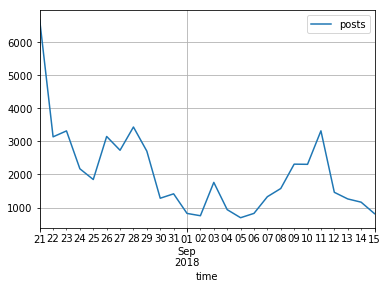

	Top Users:
		 299342620 Cab_Negro_90 0.007513924204048823
		 266438608 rayleon1515 0.007289714191794367
		 239659834 reyort06 0.004984197764500434
		 3402266699 eccehomo777 0.004959716800343759
		 3300939949 act_just 0.004937290233242428
		 1007597295116963840 lmr618686 0.004875036843129833
		 974803940637163521 laucaste11 0.0048471002676324865
		 2686068846 torres10341 0.0043428707434001275
		 859804704997560321 NadaNuevoCDMX 0.003934468088922016
		 407495701 JoseL_Cortes 0.0036958661245660683
		 331748905 richarpumas1987 0.003180158560192668
		 967787028166463489 gusfraba7 0.0024845288674366604
		 1153218793 Alfellini 0.0024456179170565845
		 459681852 beto__34 0.0023766188772201594
		 285191591 D_Gilead 0.002369395223814419
		 3600683833 Luis_C_8137 0.002347516410952159
		 2911728873 CompaJulia 0.002256623041962375
		 2820177456 trasceder 0.002165562159407688
		 149270994 RicardoSainzP 0.002158991074052278
		 68821993 drastiko1 0.002118345337043753
	Frequent Hashtags:
		 odebrecht 

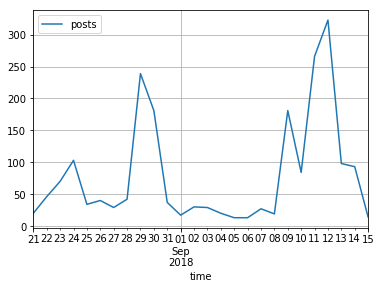

	Top Users:
		 228015335 SpryGuy 0.021171287157040204
		 826052750496632833 alan_gamm 0.011443939003805269
		 21785767 bpomalley 0.0031756930735559316
		 941850273408045056 Monkey26697239 0.003175693073555893
		 2414913756 LeChatNoire4 0.0031756930735558843
		 805112058631114752 autumnsgrammy 0.001716590850570771
		 829719370477686784 laura11lily 0.0017165908505707658
		 342772952 leotrasande 0.0017165908505707651
		 183741955 celianauburn 0.0017165908505707651
		 757358178044678144 ungubunugu1274 0.0017165908505707651
		 327022004 GeminijlwWilson 0.0017165908505707651
		 880061939010949120 PhyllisForbes17 0.0017165908505707651
		 173939001 LorraineJDion 0.0017165908505707651
		 806034284037320704 trish22bee 0.0017165908505707651
		 374283949 kenspack 0.0017165908505707651
		 28553297 kbarkerb 0.0017165908505707651
		 305661348 kristafrances 0.0017165908505707651
		 2301628435 AviFlyGirl 0.0017165908505707651
		 803066213437800448 CarrieH10987654 0.0017165908505707651
		 87474247 Wreck

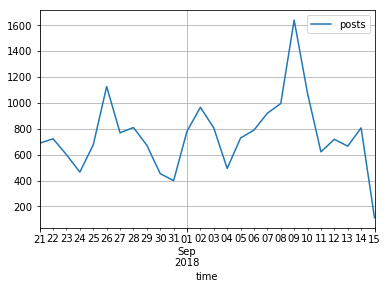

	Top Users:
		 711921323681959937 johanne_thu 0.09188559769247802
		 824398773975707649 kingcanto1 0.04993191389150731
		 1023866371690713089 EstoppelP 0.03844992631371067
		 819585050580844545 AngelMicke2 0.03650822453433547
		 955193365448085505 Dora31943588 0.03529940841600521
		 992772845041307649 AIPC_HRO 0.034688823973416764
		 987174036710060033 apocsnet 0.0284738688549941
		 917137154014351361 ebenechifu 0.024664489608354625
		 822174937226022912 lilyambas 0.02322172658921999
		 1004275620216541184 JBuhnyuy 0.02182864767642471
		 824492514014924800 Aloyzio22 0.021469737837446375
		 109686828 peterndula 0.020536322153311134
		 819760235552370688 plessrealest 0.013501794379569857
		 822232608251801601 Rosalin1613 0.012625005011535441
		 749720532673818624 bamendasheriff1 0.011963180989926254
		 475976640 ReliableBarack 0.011391316120859515
		 4451599415 CorineDonard 0.0113439783178928
		 913593971531587584 shufai100 0.010235004581203392
		 823554926395539456 eenglishwithus 0.0090

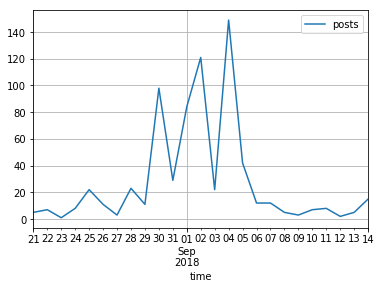

	Top Users:
		 930140168996220928 RayhanTweets 0.023965717137028605
		 909402144364797952 Usman35606587 0.012489176536198047
		 160536644 jaayjunaid 0.012489176536198016
		 295788435 huma2910 0.012489176536198016
		 272989689 OnePakistani 0.012489176536198016
		 95151029 InsafPK 0.012489176536198016
		 877863663683620865 KhalidRadical 0.012489176536198016
		 2451046626 imnewsexplorer 0.011740706497013463
		 1008639079662194689 FaizanFUR 0.011740706497013463
		 2805434941 zohaibaamir27 0.006750906235782743
		 1003819265907191810 Kashif83834503 0.006750906235782743
		 929286878469214208 Chintu_insaf 0.006750906235782742
		 2953662626 imrankhan0990 0.006750906235782742
		 1005100557365862400 sarfrazawan1430 0.006750906235782742
		 1007604076056580096 SaadRehman_15 0.006750906235782742
		 836338198406172672 iamusmanafazal 0.006750906235782742
		 895084298 MUHSANSOLANGI 0.006750906235782742
		 861317714404683777 Patriotpakista2 0.006750906235782742
		 216832350 IMRAN_AHMADKHAN 0.00675090623

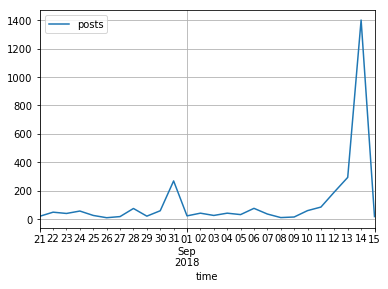

	Top Users:
		 151467226 uonbi 0.18626739982353874
		 3290139207 vcuonbi 0.0759009275949373
		 912909378583490560 IWangarimaathai 0.06023704530007107
		 115141256 KTNKenya 0.05519486882383473
		 39520708 CKirubi 0.025641114367283054
		 53037279 StandardKenya 0.024910712573239905
		 631777633 C4DLab 0.02361584081052558
		 2969435825 KaizerObed 0.023567129109997656
		 617318502 1Amreen 0.020338904893763315
		 776627096 ViridianaWasike 0.016829270782066363
		 935609819058368512 accelevateleads 0.014623805330858716
		 84898347 Nanyingih 0.01387892642259066
		 2752080493 KTNNews 0.013515962277093646
		 753133895860772864 nyagah_kaira 0.01302793410806576
		 3214281477 NairobiIW 0.012034946230638102
		 25985333 ntvkenya 0.011882294130678919
		 842224716572176388 NMGLeadersForum 0.011453118166242929
		 1324492021 uoncees 0.010634343781507146
		 804695644602568705 kevinwere01 0.010537450511700058
		 453730683 EllyMathenge 0.008869221811056942
	Frequent Hashtags:
		 uongraduation 706
		 uonclass

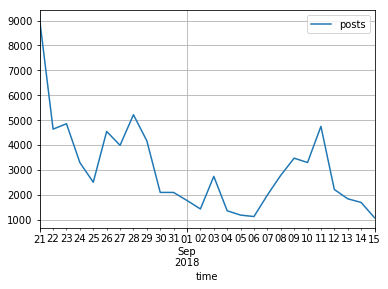

	Top Users:
		 82788234 alvaro_delgado 0.2443953749395922
		 54649261 epigmenioibarra 0.03229897986053823
		 3995251693 _markgerard 0.02190127991408242
		 249812258 lovrega 0.021461671634236842
		 153276656 m_zamarripa 0.017252155450033283
		 3227489102 AntiTelevisaMx 0.013739096748029997
		 1581079028 cesamo70 0.011713753982325121
		 43115590 fernandeznorona 0.010668029704975358
		 124919375 MADREABC 0.009150542244825487
		 118782324 annaazul 0.007119187560144294
		 279873322 AntonioRHidalgo 0.006871710846730056
		 799979376754331648 BibiMonteroDR 0.006659102989343051
		 274218280 periodistafrg 0.005770467523739507
		 112482127 saos50 0.0056867801332440805
		 173604505 lauratenacolung 0.005523638686324034
		 700409337508974593 poisonJadeVine 0.005460504091342834
		 85697134 Navegaciones 0.005007799118256031
		 68723105 NachoRgz 0.004775924875842709
		 166657017 cecortesr 0.004760195232504124
		 1012400465944948742 TUCAMfracasado 0.004523499244052504
	Frequent Hashtags:
		 odebrecht 13

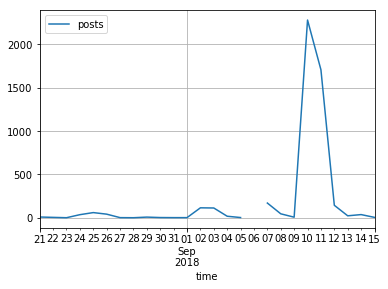

	Top Users:
		 80047141 TAMARA_SUJU 0.32005379360872116
		 1610496259 MaihenH 0.18936606813902446
		 955624977054740480 SOSOrinoco 0.17303815030397002
		 36278714 pburelli 0.06065229221832541
		 262724808 elindiocitadino 0.020885419702994786
		 49816653 vjlosarcosayape 0.016560158901662504
		 3997973783 Leonius1 0.01480564953595123
		 142111803 romeroreimer 0.013100661473460578
		 784076685117419520 QuitoVenezuela 0.010375436861470043
		 126427570 masagadi 0.008556992816134285
		 2755141118 MusashiM1 0.0036779066019382465
		 1171105333 tuiteraexitosa 0.003042065121602949
		 958082338604421121 OmarOrlandoMon1 0.0029720165851868235
		 2751012341 managuac 0.002964280513842743
		 862038558 obendjoya 0.0022966939008081133
		 607446496 SoyLaEmperatriz 0.0015872598145967893
		 115252281 rivaedua 0.0015563155292204756
		 1096218464 nomeolvid1 0.001523931974756894
		 2360637179 bartvalletta 0.001417066245027067
		 76139897 SilvaClarisa 0.001417066245027066
	Frequent Hashtags:
		 sosvenezuela 21

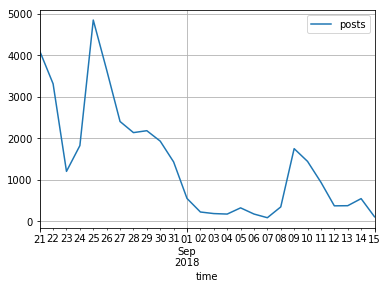

	Top Users:
		 144376833 FelipeCalderon 0.07589823569961406
		 3072835883 tumbaburross 0.023357273559587877
		 1223168594 DivinoTormento9 0.022054356739179277
		 1206226568 AlanPonce_29 0.021145365954657862
		 148918046 AlmaMaderoB 0.02015117897058683
		 205930355 dianarouzaud 0.019054100506375498
		 240858817 TAMBORRELmx 0.018864069877338182
		 51798186 ivonnemelgar 0.012645162066015597
		 1018572319332192256 hugopaezoficial 0.012297151986889748
		 112504633 CarlosTorresF_ 0.011123208776141171
		 212083458 LARA_MEXICO 0.009366504948565368
		 799754031723737088 SerpienYEscaler 0.009366504948565354
		 479822306 AsiEsMonterrey 0.009366504948565349
		 114346861 ferbelaunzaran 0.008426565640465624
		 167042901 GlodeJo07 0.008077612965822215
		 1957798104 CartonCalderon 0.00751799388146404
		 103963822 mileniotv 0.007356234043502636
		 3105153260 JPAlvarezGuedea 0.007084508070488331
		 161514426 LICCSANCHEZ 0.006890529811619537
		 156490072 ANDROMACO64 0.005567352699860037
	Frequent Hashtag

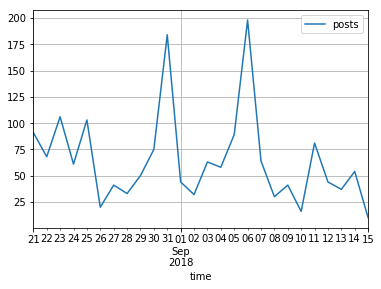

	Top Users:
		 358700867 madugian 0.07325153267254932
		 3452339836 adomakoampofo 0.025174728048348978
		 925722616823975936 freebobiwine 0.02187536732211676
		 863795456622645248 Bnizeye1 0.02187536732211452
		 18971988 niikotei 0.021550872693023783
		 365521605 YDTetteh 0.020156318026238882
		 204367551 Makahorney 0.011528068517774636
		 1599146420 AmaTuffet 0.009507685375484232
		 34415870 BlueBirdTail 0.0070001175430773705
		 352201264 bashlima 0.006070414431887413
		 596357797 JoshMushwa 0.00607041443188741
		 879681442640482304 favored_ivy 0.006070414431887405
		 884095927828590592 Reelani18 0.006070414431887405
		 1465742112 FfeTwakoowa 0.006070414431887405
		 211481870 lebo_diseko 0.004914448138335601
		 578353910 mlnangalama 0.004675859765102473
		 702888818 AllanLuwagga 0.003281305098317529
		 148699859 BMKGift 0.003281305098317529
		 1215297115 JUNIORGILBERT3 0.003281305098317529
		 368274481 XenonAz 0.003281305098317529
	Frequent Hashtags:
		 freebobiwine 52
		 bobiwine 46


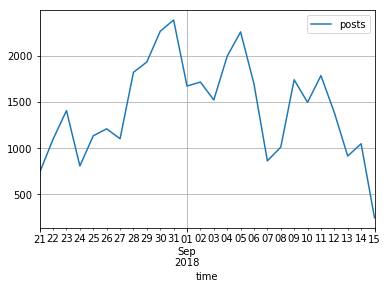

	Top Users:
		 122448174 BiancaJagger 0.1385667797735309
		 305835391 camilocnn 0.0814706854806833
		 51771408 AvilRamirez 0.061564164527761533
		 881333279223406596 Humbert13545425 0.03830957101942516
		 1012538425625513986 EnlaceLeonNic 0.021384276362234278
		 6135622 dw_espanol 0.009693066216900423
		 990591808873947136 Anon1moNica 0.008722784815633206
		 86444881 laprensa 0.008564262449808499
		 1532298012 OcupaINSS 0.008547598368495364
		 990295791645413376 CudjNicaragua 0.00755380960709026
		 2196023400 F24Debate 0.006968644775918446
		 1584684470 silviojbaez 0.005230100552718504
		 69205157 cefeche 0.00501442462006313
		 987017079126667264 VeritoVandalica 0.004108498960057582
		 115991332 ElmResistencia 0.0034889614354022547
		 139995624 AliciaOficial 0.0033538267845196366
		 879144538362834948 carmelitequotes 0.0031575749858400093
		 908180407946018816 Articulo66Nica 0.003101809316917169
		 384933011 haroldsnica 0.0030447448503906805
		 132248149 CSMaldonado 0.00303765168651799

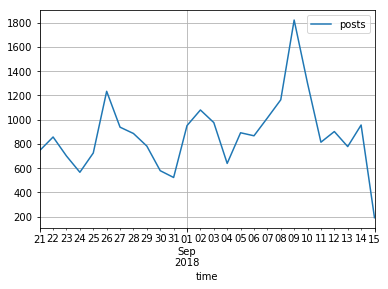

	Top Users:
		 863703891652882433 scbc_tv 0.08933121488863924
		 937298996783124480 Secominfo 0.07904427242474481
		 907310151274778625 samaraysama 0.0488590749453313
		 1002672993007435777 Freedom73819264 0.044139076607398735
		 869227030809903104 mbahjustice 0.024848984117336492
		 595181838 DianaBrandes 0.016391732724564585
		 1001419591581683712 AshuKemi 0.014493022594221833
		 931175780423417856 EAnalyser 0.014180763479876924
		 1003040231887724545 CelestAtanga 0.011996327864118483
		 2940644067 jokraniareflex1 0.01128129293487375
		 823094395918548992 DifangAko 0.011160481450926315
		 346226859 NikChama 0.011033962097425782
		 3690282255 judithnwana 0.011010171007925139
		 906308915985600514 AmbaPikin 0.010678839823597814
		 1006854313187082241 SoyaFor 0.01051341262386875
		 1027044042578845696 AgehNjwoman 0.010378829472923937
		 250709191 ChrisFomunyoh 0.010336901231365632
		 1694601942 milly4red 0.010160156740561175
		 14795451 innercitypress 0.009772213726795856
		 10022702504

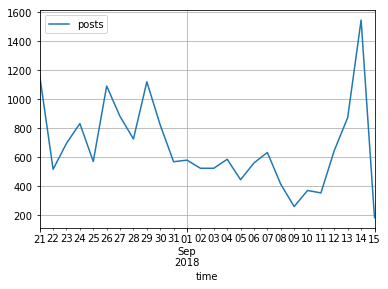

	Top Users:
		 1002612294294097921 NwaCHUK20830123 0.05605764449767225
		 3510322036 udumaokoro3 0.02511591885535526
		 3695631375 JeromIzuchukwu 0.016444493703417433
		 274136474 donbosco06 0.01576923671559532
		 855972614845673472 AAzalagha 0.014761978375428279
		 1020674224380424192 GeorgeB12888298 0.011267523463452406
		 2275798472 RealKaluAgwu 0.011267523463452288
		 777103966668718081 okikeamaka1 0.011267523463452202
		 2174637904 alexe42261051 0.010191026816201113
		 835502550916956162 EmmaNwOrie 0.0060905532234879186
		 990647293996085249 Nwokedialexgma1 0.006090553223487768
		 902669723510419457 intel_face 0.006090553223487768
		 959868878452076544 Joepec1001 0.006090553223487736
		 821652305686761472 samuel_ekeke 0.006090553223487736
		 371251573 okirikooo 0.006090553223487733
		 980064311413542912 RitaNgozi17 0.006090553223487726
		 2187732998 agujiegbebiafra 0.006090553223487724
		 801145013799358468 JoyOnyejekwe 0.005290549964824
		 949914034618343424 AnavoChukwudi 0.00407

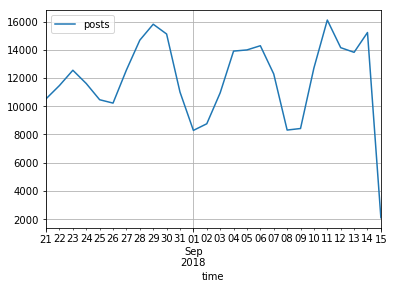

	Top Users:
		 17463923 UNFCCC 0.025011904986930202
		 36670025 BBCAfrica 0.02426212760708757
		 96735431 AfDB_Group 0.01927777656426904
		 38146999 UNEnvironment 0.015745959592455373
		 27860681 WorldBank 0.012380714954152154
		 48702842 ErikSolheim 0.012126193306834067
		 540734980 GlobalLF 0.01007939670109115
		 569238628 BBCMonitoring 0.00891047645037977
		 25387183 ReutersAfrica 0.008487430870221309
		 214842351 PEspinosaC 0.007536696874727006
		 1372641625 RichardMunang 0.006905910795279999
		 811229675758505984 antonioguterres 0.0057233465360440145
		 3353546133 evaluationafdb 0.005674377810168143
		 237742285 burke_jason 0.00519493040814282
		 243232918 WandileSihlobo 0.004803373165227721
		 195634515 Backarray 0.004473798410154195
		 1004681701644091392 JoyceMsuya 0.004289414555332669
		 14159148 UN 0.004282942593735167
		 36683668 USAID 0.00409828061729807
		 135187648 WorldBankAfrica 0.003742566759211493
	Frequent Hashtags:
		 climatechange 9464
		 africa 6690
		 glfnairobi2

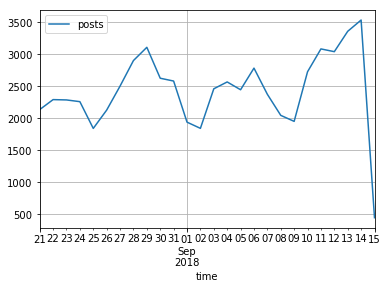

	Top Users:
		 27740227 mongabay 0.03326774030486753
		 87253645 jcatanoso 0.023699894424581553
		 164620984 bmu 0.012830638850395785
		 479816451 MarkTercek 0.010376953735243812
		 475165737 jeffrey_ventre 0.007681179588617385
		 971954447181066240 AFL_org 0.00737356588582762
		 269978527 foresttrendsorg 0.007121057134765693
		 90403900 AidaGreenbury 0.006869184492943518
		 2358015139 ErikHoffner 0.005329181102528431
		 2203415041 GusGreenstein 0.00474208691176905
		 627124299 darylsghourl 0.004355604502777034
		 757979230244368385 SvenjaSchulze68 0.0043110795901334
		 978604706 CopernicusEU 0.004085097732942784
		 610952363 NatCapCoalition 0.003851634253872365
		 609234918 sjoscl 0.0034652270041044034
		 619965810 Stuart_Orr 0.003394000323524075
		 400819127 JacobDuer 0.003376277223725408
		 53864502 XavMars 0.0033018552410453033
		 4017972017 resource_watch 0.0031686461547725422
		 324599106 jeremy_hance 0.003152398025564317
	Frequent Hashtags:
		 climatechange 3284
		 gcas2018 1198

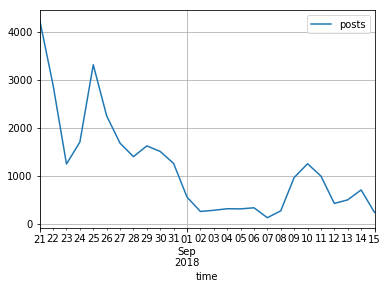

	Top Users:
		 578730531 skyaquaklin 0.02321844167478459
		 2856056140 marialuisalg1 0.021545822107585214
		 623613973 Juan1250Mexico 0.02126619764666075
		 228111394 BiRuano 0.020100119829392735
		 2912436454 JoaRubalcava 0.01747431423556908
		 571903598 cucebrio1 0.015338558166046864
		 85204365 MagdaGraciasFCH 0.014274639783210192
		 110260249 AnitaAldBel 0.012851509337016285
		 982384647064596480 elyvel1609 0.012704534851266496
		 448353068 carmen_olvera 0.012352649899554948
		 385488792 FerVazquez3 0.011998734377833144
		 457176639 rociogl36 0.011080913732180836
		 316487653 HectorArellanoT 0.009915151881210163
		 1034631061320491009 asardanna79 0.00973670729592719
		 141689621 MarcehTam 0.009026524369937726
		 1470753973 ysenger 0.00819826468353372
		 434644525 lmoy_a 0.007744294235787942
		 63514429 ManuelVegaCln 0.0077372729273493925
		 152856193 quelacion 0.007350167490674276
		 3097903809 caroescer 0.0057084231270010015
	Frequent Hashtags:
		 renewables 351
		 nce2018 133
		 

In [19]:
narrow_users = []

comm_weights = {}

# Iterate through the communities and trim ones of smallish size
for comm_id, comm_members in community_map.items():

    # We'll skip small communities
    if ( len(comm_members) < 100 ):
        continue
        
    lprint("Community: %d" % comm_id, user_ids_to_names[comm_id])
    lprint("\tUser Count: %d" % len(comm_members))
    
#     if ( comm_id in target_communities ):
#         narrow_users.extend(comm_members)

    # Get relevant tweets
    filtered_tweets = tweets.filter(lambda tweet: is_in_user_id(tweet, comm_members)).cache()
    
    # Use the username set produced by our community generator to 
    #  create a subgraph of only these users and the connections
    #  between them.
    subg = rtgraph.subgraph(comm_members)
    
    density = nx.density(subg)
    lprint("\tNetwork Density:", density)
    
    # Plot times
    plot_times(filtered_tweets, comm_members, ("%s.pdf" % user_ids_to_names[comm_id]))
    
    # Given the subgraph...
    #  find the most authoritative nodes,
    local_targets = find_auth_nodes(subg, user_ids_to_names, limit=20)
    
    comm_weights[comm_id] = local_targets
    
    #  the most frequent hashtags, and
    user_hashtags(filtered_tweets, limit=20)
    
#     #  then visualize the network
#     draw_graph(subg, "%s.graphml" % user_ids_to_names[comm_id])

    filtered_tweets.unpersist()

In [20]:
user_ids_to_names[166669818]

'VicenteFoxQue'

In [16]:
lprint("test", "testing")

test testing


In [69]:
print("h")

h
